# Data and Empirics

In today's session we will start to explore how to actually work with data in an interesting way. At least, interesting to us economists. 

We will start by finding some data and getting it ready to work with. Then, we will look at how to do a simple linear regression, before expanding that to multiple variables. If we have time, we will also see how to look for endogeneity and omitted variable bias and how to deal with it using two-stage least squares. 

First, let's start by importing the main packages we will be using:

In [14]:
# These are the standard packages we regularly use:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This package is going to give us basic econometric functions:
import statsmodels.api as sm # This is where we will get OLS
from statsmodels.iolib.summary2 import summary_col # This is a handy way to look at model results side-by-side

# For IV, we will need to pull from another package that is not included in Anaconda, so we need to install it:
# !pip install linearmodels
from linearmodels.iv import IV2SLS

Great, now let's find some data to work with. The "textbook" replicates a paper by Acemoglu, Johnson, and Robinson. You can find that paper [here](https://economics.mit.edu/files/4123) along with the data [here](https://economics.mit.edu/faculty/acemoglu/data/ajr2001). We'll be replicating Table 1 from the paper, so we'll just need the data for that part. You can also find the data in our GitHub repository, [here](https://github.com/UC-Davis-ARE-Econ/Python_Boot_Camp/blob/master/Data/maketable1.dta). 

## Importing Data
Oh damn. Those fools used Stata, so now we have to deal with a `.dta` file. Well, it's a good thing that Pandas lets us do that very easily:

In [15]:
df1 = pd.read_stata('https://github.com/UC-Davis-ARE-Econ/Python_Boot_Camp/raw/master/Data/maketable1.dta')
df1.head()

shortnam   euro1900  excolony    avexpr  logpgp95  cons1  cons90  democ00a  \
0      AFG   0.000000       1.0       NaN       NaN    1.0     2.0       1.0   
1      AGO   8.000000       1.0  5.363636  7.770645    3.0     3.0       0.0   
2      ARE   0.000000       1.0  7.181818  9.804219    NaN     NaN       NaN   
3      ARG  60.000004       1.0  6.386364  9.133459    1.0     6.0       3.0   
4      ARM   0.000000       0.0       NaN  7.682482    NaN     NaN       NaN   

   cons00a    extmort4    logem4  loghjypl  baseco  
0      1.0   93.699997  4.540098       NaN     NaN  
1      1.0  280.000000  5.634789 -3.411248     1.0  
2      NaN         NaN       NaN       NaN     NaN  
3      3.0   68.900002  4.232656 -0.872274     1.0  
4      NaN         NaN       NaN       NaN     NaN

So now we have some data. Specifically, we have GDP per capita across countries for 1995 and differences in institutions across countries. We are interested in seeing whether these institutional differences lead to different economic outcomes.

As any good economist knows, we should always start with the Mark 1 Eyeball Test™. Let's graph GDP per capita against one of these institutional indices, say "protection against expropriation". Honestly, I have only a slight inkling as to what that means, and I have no idea how the authors measure it, but let's see what there is to see:

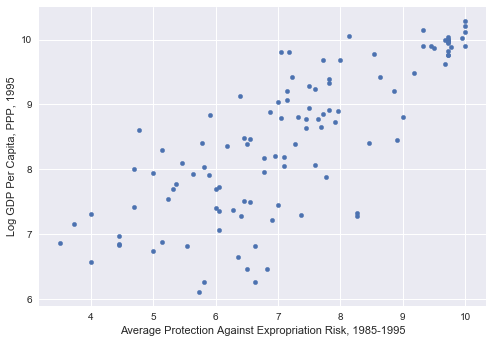

In [20]:
plt.style.use('seaborn')

df1.plot(x = 'avexpr', y = 'logpgp95', kind = 'scatter')
plt.xlabel('Average Protection Against Expropriation Risk, 1985-1995')
plt.ylabel('Log GDP Per Capita, PPP, 1995')
plt.show()

We can see that it might be possible to represent this with a linear relationship. So let's try a simple linear model, maybe something like:
$$logpgp95_i = \beta_0 + \beta_1 avexpr_i + u_i$$
In order to estimate this model there is a bit of data cleaning we ought to do first.

## Data Cleaning
First, we need to get rid of any `NA` values in the data, in order to satisfy the underlying Numpy function `polyfit`.

In [22]:
# Drop NAs to work with polyfit:
df1_subset = df1.dropna(subset = ['logpgp95', 'avexpr'])

Now that we have a subset without any pesky `NA`s, let's plot our data with a best fit line.

## Plotting a Best Fit Line

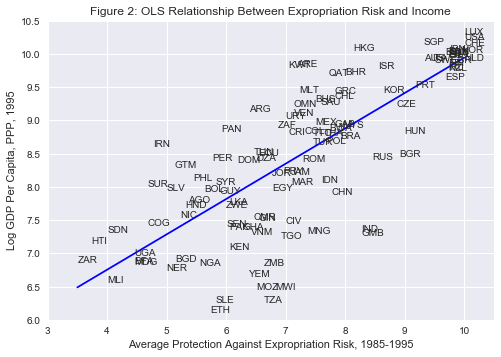

In [28]:
# Tell it what the X and y are:
X = df1_subset['avexpr'] # Protection from expropriation is our explanatory variable
y = df1_subset['logpgp95'] # Log per capita GDP is the dependent variable

# Let's label the points in the graph with the country names:
labels = df1_subset['shortnam']
fig, ax = plt.subplots() # This should be familiar from Shanchao's Week 2 notes
ax.scatter(X, y, marker = '') # Telling it to create a scatter plot with no marker points

for i, label in enumerate(labels):
    ax.annotate(label, (X.iloc[i], y.iloc[i])) # Take point (X, y) and label it with it's country name

# Fit linear trend:
ax.plot(np.unique(X),
       np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
       color = "blue")

# Make it look nice:
ax.set_xlabel('Average Protection Against Expropriation Risk, 1985-1995')
ax.set_ylabel('Log GDP Per Capita, PPP, 1995')
ax.set_title('Figure 2: OLS Relationship Between Expropriation Risk and Income')
ax.set_xlim([3, 10.5])
ax.set_ylim([6, 10.5])
plt.show()

Cool. But what exactly did we do here? Most of it was just Pyplot stuff, but let's look at fitting the linear trend specifically. We used this code:
```
ax.plot(np.unique(X),
       np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
       color = "blue")
```
First, we're using the `plot` function on the `ax` object. This function simply plots an "x" against a "y" using either a line or points, depending on what you tell it. We're using three arguments here, first telling it the "x" value, then the "y" value, then the color of the line.

Obviously the color is straightforward, but let's look at the "x" and "y" values. The "x" points are all of the unique values in the variable `X`. So these are the unique values for the average protection against expropriation, since we don't care about any repeated points. 

The "y" values are a little more interesting. This is a very short way to write out what is actually several things happening at ones. The `np.poly1d` function has one argument, which itself is the `np.polyfit` function. Let's look at what this does when given our data:

In [36]:
fit = np.polyfit(X, y, 1)
fit

array([0.53187135, 4.62608941])

This gives us a Numpy array with two values: the OLS coefficient on `X` and the intercept. The `1` in the third argument is an indicator of the degree of the polynomial we are requesting to be fit.

So now we have estimated coefficients of a polynomial. Well, `np.poly1d` lets us evaluate that polynomial with the coefficients specified

In [39]:
poly = np.poly1d(fit)
print(poly)

 
0.5319 x + 4.626


Look at that, a nice linear regression equation. That polynomial, which we named `poly`, can also take an argument, a value for "x" at which to evaluate the polynomial:

In [44]:
poly(np.unique(X))

array([6.4876394, 6.6085196, 6.7535753, 6.9953346, 7.1162148, 7.164567 ,
       7.285446 , 7.357974 , 7.4063263, 7.4546785, 7.478854 , 7.5272064,
       7.575558 , 7.62391  , 7.672262 , 7.696438 , 7.720614 , 7.756878 ,
       7.7689657, 7.817318 , 7.8414936, 7.9140215, 7.9623737, 8.010726 ,
       8.022814 , 8.034902 , 8.059077 , 8.083254 , 8.1074295, 8.155781 ,
       8.22831  , 8.252485 , 8.276661 , 8.3008375, 8.325013 , 8.34919  ,
       8.373365 , 8.397541 , 8.421717 , 8.445893 , 8.470069 , 8.494246 ,
       8.518421 , 8.542597 , 8.590949 , 8.615125 , 8.663477 , 8.687653 ,
       8.711828 , 8.736005 , 8.760181 , 8.784357 , 8.832708 , 8.856884 ,
       8.881061 , 8.9535885, 9.026116 , 9.12282  , 9.171173 , 9.219524 ,
       9.3404045, 9.36458  , 9.412931 , 9.509636 , 9.582164 , 9.654692 ,
       9.678867 , 9.775572 , 9.799747 , 9.823923 , 9.920628 , 9.944803 ],
      dtype=float32)

We can see that giving it the array of unique values in `X` gives us back the fitted values. So this is what we are plotting in the "y" dimension in the figure above. 

## Ordinary Least Squares

Now that we have seen how to plot the linear regression model, let's actually turn the the `statsmodels` package and estimate some stats models. 

One thing we need to consider first is the intercept. While most statistical programs we have used before will assume an intercept unless told otherwise, Python will not assume anything about what you want. So we have to tell it that we want an intercept. We do this by adding a column of ones to our data:

In [47]:
df1['const'] = 1
df1.head()

shortnam   euro1900  excolony    avexpr  logpgp95  cons1  cons90  democ00a  \
0      AFG   0.000000       1.0       NaN       NaN    1.0     2.0       1.0   
1      AGO   8.000000       1.0  5.363636  7.770645    3.0     3.0       0.0   
2      ARE   0.000000       1.0  7.181818  9.804219    NaN     NaN       NaN   
3      ARG  60.000004       1.0  6.386364  9.133459    1.0     6.0       3.0   
4      ARM   0.000000       0.0       NaN  7.682482    NaN     NaN       NaN   

   cons00a    extmort4    logem4  loghjypl  baseco  const  
0      1.0   93.699997  4.540098       NaN     NaN      1  
1      1.0  280.000000  5.634789 -3.411248     1.0      1  
2      NaN         NaN       NaN       NaN     NaN      1  
3      3.0   68.900002  4.232656 -0.872274     1.0      1  
4      NaN         NaN       NaN       NaN     NaN      1

Easy peasy. Now we have a new variable that will give us a constant. The functions that we will use for OLS from `statsmodels` will accept either `pandas` dataframes or `numpy` arrays. Conveniently, the function for OLS in `statsmodels` is just called `OLS`.

In [48]:
reg1 = sm.OLS(endog = df1['logpgp95'], exog = df1[['const', 'avexpr']], missing = 'drop')

We can see that the arguments for `OLS` are nicely labeled. `endog` for the endogenous variable, `exog` for the exogenous variables (including the constant), and `missing` to tell the function what to do with missing values. Note that `endog` must be one-dimensional, while `exog` can be an $n \times k$ array. `missing` can be either `none`, `drop`, or `raise`. `none` tells the function not to worry about missing values, `drop` tells the function to drop them from the data, and `raise` tells the function to give you an error if it finds missing values.

So what are the estimated parameters of the model? Now that we have the model object, `reg1`, we can use a method, `.fit()` to operate on it and extract the fitted parameters. We will then use another method, `.summary()` on the results to display them in a readable format:

In [53]:
results1 = reg1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Thu, 09 Jan 2020   Prob (F-statistic):           4.16e-24
Time:                        21:48:02   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.0

Isn't that nice looking? We even have several common tests and a nice warning reminding us that we are assuming correctly specified errors. This is again obvious where it tells us the covariance type is `nonrobust`. Obviously that's crazy, as we all know. Let's get back to that in a second.

What if you just need to extract the parameter values for something? That's actually not too difficult, they are stored as attributes of what we have called the `results1` object:

In [68]:
print(results1.params)
β = results1.params['avexpr']
print("β =", β)

const     4.626089
avexpr    0.531871
dtype: float64
β = 0.5318713487182616


Obviously there are lots of values we might be interested in. It's easy to see what can be extracted from the results by using the `dir()` function:

In [69]:
dir(results1)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_robustcov_results',
 '_is_nested',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'initialize',
 'k_constant',
 'llf',
 'load',
 'model',


Oh look, there's attributes like `HC0_se`, `HC1_se`, and so on. That's useful, it shows us that we can extracted the robust standard errors if we need them. 

But what if we want robust standard errors in our summary table? Then, it just so happens that the `.fit()` method we used previously takes an argument telling it to use robust standard errors in producing the results:

In [72]:
robust_results = reg1.fit(cov_type = 'HC0')
print(robust_results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     340.9
Date:                Thu, 09 Jan 2020   Prob (F-statistic):           2.43e-35
Time:                        22:07:50   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.238     19.398      0.0

Nice. That should make us all rest a little easier.